# Transformer Model Architecture

In [1]:
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Embedding

warnings.filterwarnings('ignore', category=UserWarning)

2024-10-15 14:31:54.671092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[<img src="./images/transformer/transformer_model_architecture.png" style="max-width:30%;margin: auto;display: block;"/>](attachment:ec136c3d-89a4-4586-ae2e-5ce2df4576dd.png)
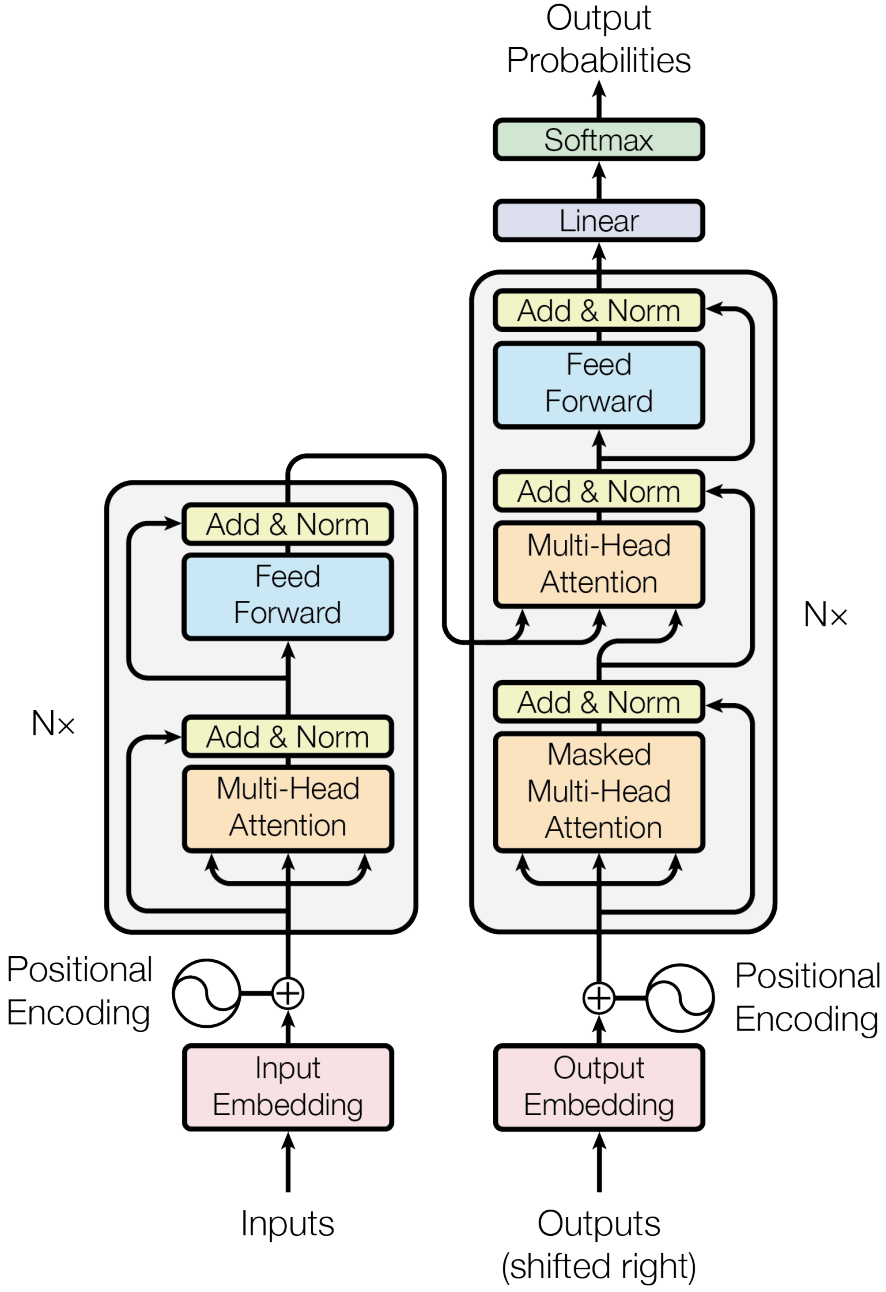

## Positional Encoding

[<img src="./images/transformer/positional_encoding.png" style="max-width:40%"/>](attachment:4201ef71-8d88-4342-b521-13bd7e12cdf4.png)

In [2]:
def positional_encoding(position, d_model):
    # Generate a matrix of angles using positions and dimensions for scaling (shape: [position, d_model])
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))

    # Apply sine & cosine to the even & odd indices in the angle matrix
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # Add a new batch dimension and convert the result to float32
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

## Multi-head Attention

[<img src="./images/transformer/attention_score.png" style="max-width:40%"/>](attachment:788e7537-f752-416e-a15c-2bc79aab2305.png)
[<img src="./images/transformer/multi-head_attention.png" style="max-width:60%"/>](attachment:edc9e806-9417-448b-ac65-dbad97dda31a.png)
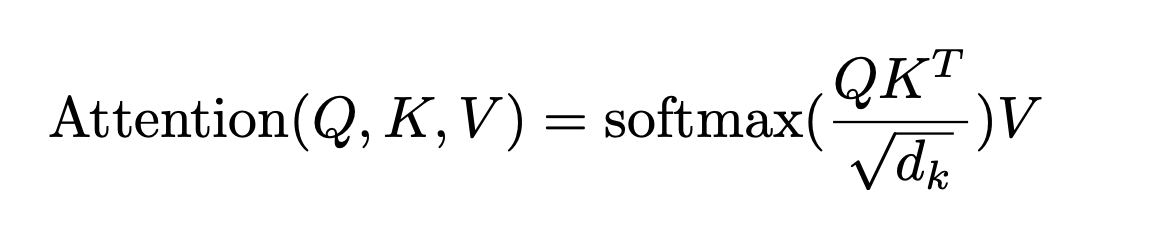
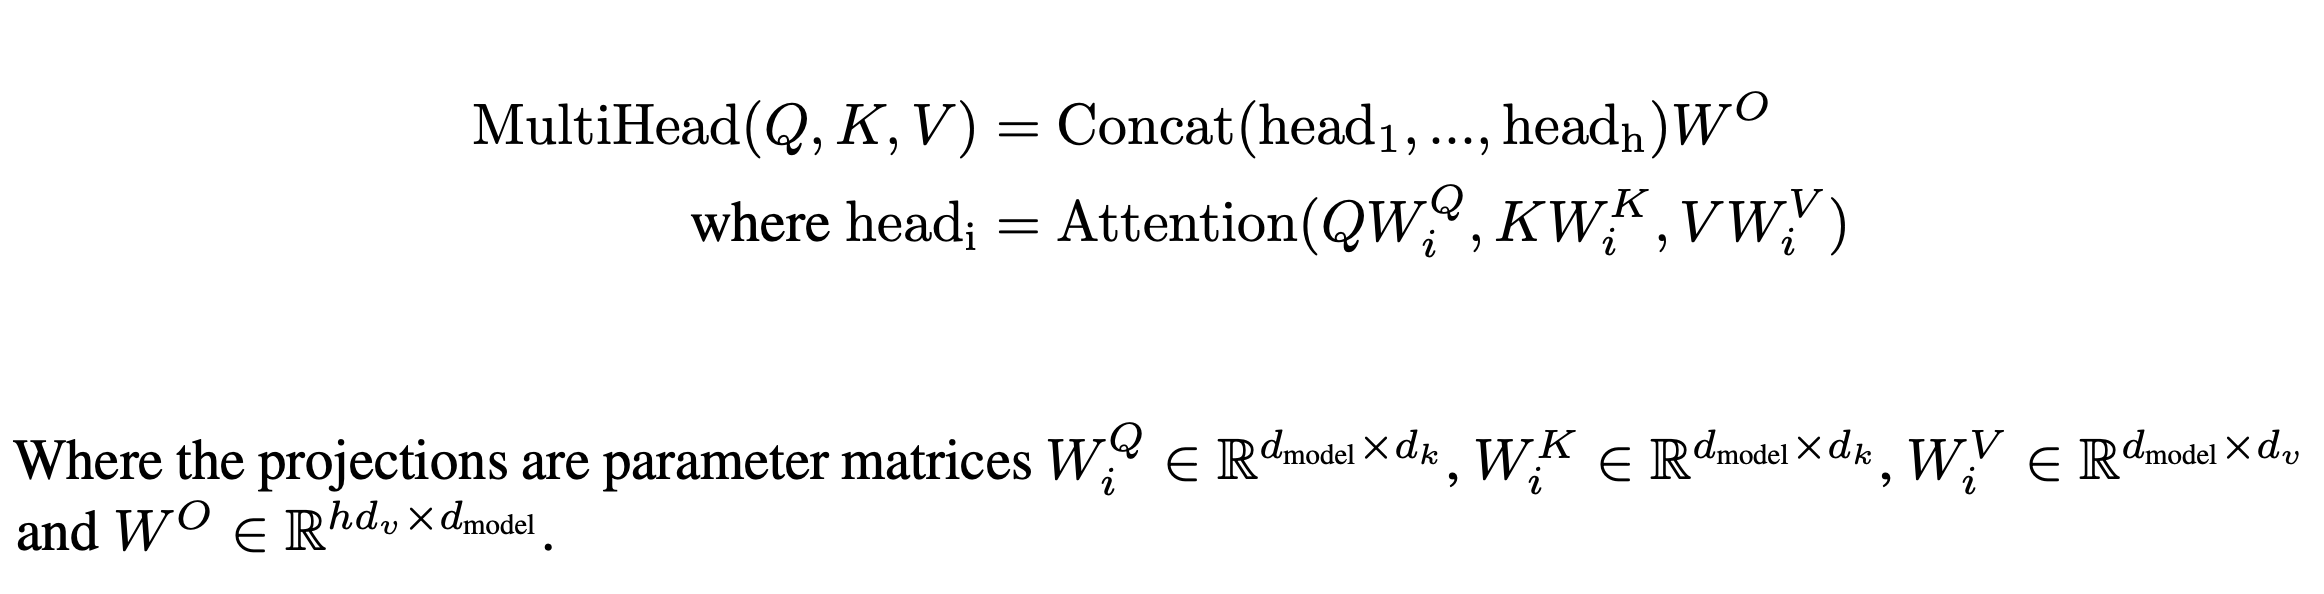

In [3]:
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        # Set the model dimensionality and number of attention heads
        self.d_model = d_model
        self.num_heads = num_heads

        # Calculate depth of each attention head
        self.depth = d_model // num_heads

        # The query is what you're trying to find.
        # The key is what sort of information the dictionary has.
        # The value is that information.

        # Define dense/linear layers to create query, key, and value vectors
        self.wq = Dense(d_model) # what you're trying to attend to
        self.wk = Dense(d_model) # what you're comparing against
        self.wv = Dense(d_model) # the information you're retrieving

        # Output linear layer to project concatenated attention heads back to d_model
        self.dense = Dense(d_model)

    # Function to reshape and split inputs into multiple heads
    def split_heads(self, x, batch_size):
        # Reshape x to have shape [batch_size, seq_len, num_heads, depth]
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))

        # Transpose to [batch_size, num_heads, seq_len, depth] to prepare for multi-head attention
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        # Get the batch size from the query tensor
        batch_size = tf.shape(q)[0]

        # Pass queries, keys, and values through respective dense layers
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Split queries, keys, and values into multiple heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        # Transpose the attention output back to [batch_size, seq_len, num_heads, depth]
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])

        # Reshape the attention output to [batch_size, seq_len, d_model] for concatenation
        attention = tf.reshape(attention, (batch_size, -1, self.d_model))

        # Pass the concatenated attention output through the final dense layer
        output = self.dense(attention)
        return output
        
    def scaled_dot_product_attention(self, q, k, v, mask):
        # Compute the dot product of queries and keys, transpose k for correct alignment
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale the attention logits by the square root of the key depth
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply the mask, if provided, to prevent attending to certain positions
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Apply softmax to get the attention weights (probabilities)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Multiply the attention weights with the values to get the final attention output
        output = tf.matmul(attention_weights, v)
        
        return output, attention_weights

## Position-wise Feed-Forward Network

[<img src="./images/transformer/point-wise_feedforward.png" style="max-width:40%"/>](attachment:2ee392ff-23a8-479f-b4d4-5cbd65f35305.png)
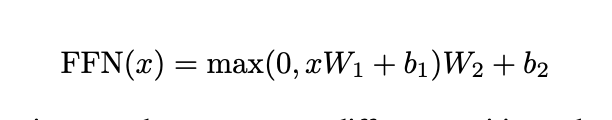

In [4]:
class PositionwiseFeedforward(Layer):
    def __init__(self, d_model, dff):
        super(PositionwiseFeedforward, self).__init__()

        # Dimensionality of the hidden & output layers
        self.dff = dff
        self.d_model = d_model

        # First dense layer with ReLU activation
        self.dense1 = Dense(dff, activation='relu')
        
        # Second dense layer without activation (linear transformation)
        self.dense2 = Dense(d_model)

    def call(self, x):
        # Apply the first transformation (expansion + ReLU)
        x = self.dense1(x)
        
        # Apply the second transformation (compression to d_model)
        x = self.dense2(x)
        
        return x

## Transformer Blocks (Encoder & Decoder)

### Encoder Transformer Block

[<img src="./images/transformer/encoder_transformer_block.png" style="max-width:15%"/>](attachment:fc5c01d1-3c22-493b-bc7f-21752e2fadc6.png)
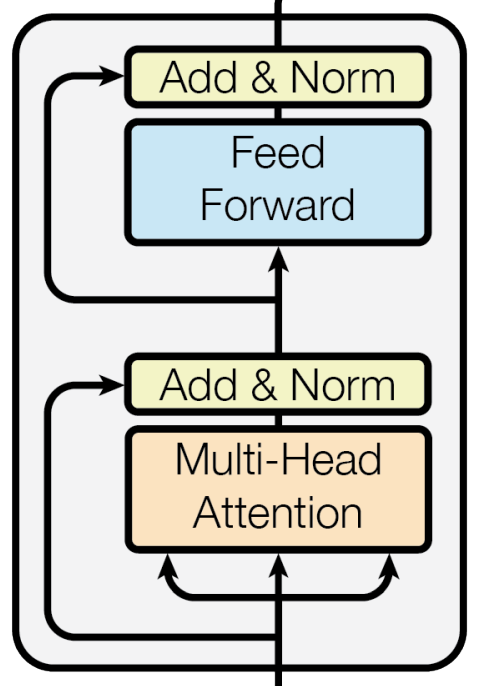

In [5]:
class EncoderTransformerBlock(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderTransformerBlock, self).__init__()

        # Multi-head attention mechanism to capture token relationships
        self.att = MultiHeadAttention(d_model, num_heads)

        # Position-wise feedforward network to process token representations
        self.ffn = PositionwiseFeedforward(d_model, dff)

        # Layer normalization to stabilize the output (after attention and feedforward)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        # Dropout layers for regularization
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training, mask):
        # Apply multi-head attention with mask (x as query, key, value)
        att_output = self.att(x, x, x, mask)
        # Apply dropout to the attention output during training
        att_output = self.dropout1(att_output, training=training)
        # Apply layer normalization to stabilize the residual output
        residual_output = x + att_output
        out1 = self.layernorm1(residual_output)

        # Apply position-wise feedforward network
        ffn_output = self.ffn(out1)
        # Apply dropout to the feedforward output during training
        ffn_output = self.dropout2(ffn_output, training=training)
        # Apply layer normalization to the final residual output
        residual_output = x + ffn_output
        out2 = self.layernorm2(residual_output)

        return out2

### Decoder Transformer Block

[<img src="./images/transformer/decoder_transformer_block.png" style="max-width:15%"/>](attachment:8159288e-842a-477d-83f0-fc9804d385f0.png)
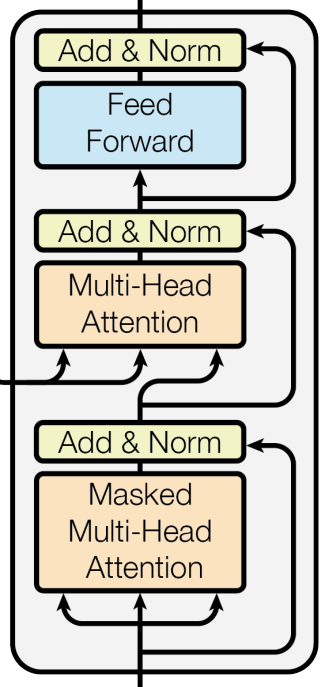

In [6]:
class DecoderTransformerBlock(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderTransformerBlock, self).__init__()

        # Multi-head attention mechanism to capture token relationships
        self.att = MultiHeadAttention(d_model, num_heads)
        # Cross-attention: query comes from decoder, keys/values come from encoder
        self.cross_att = MultiHeadAttention(d_model, num_heads)

        # Position-wise feedforward network to process token representations
        self.ffn = PositionwiseFeedforward(d_model, dff)

        # Layer normalization to stabilize the output (after attention and feedforward)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        # Dropout layers for regularization
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # Apply multi-head attention with mask (x as query, key, value)
        att_output = self.att(x, x, x, look_ahead_mask)
        # Apply dropout to the attention output during training
        att_output = self.dropout1(att_output, training=training)
        # Apply layer normalization to stabilize the residual output
        residual_output = x + att_output
        out1 = self.layernorm1(residual_output)

        # Cross-attention (decoder attending to encoder output)
        cross_att_output = self.cross_att(out1, enc_output, enc_output, padding_mask)
        cross_att_output = self.dropout2(cross_att_output, training=training)
        # Residual connection and layer normalization
        residual_output = out1 + cross_att_output
        out2 = self.layernorm2(residual_output)

        # Apply position-wise feedforward network
        ffn_output = self.ffn(out2)
        # Apply dropout to the feedforward output during training
        ffn_output = self.dropout2(ffn_output, training=training)
        # Apply layer normalization to the final residual output
        residual_output = out2 + ffn_output
        out3 = self.layernorm2(residual_output)

        return out3

## Encoder Stacks

[<img src="./images/transformer/encoder_stacks.png" style="max-width:20%"/>](attachment:fc1e200d-c965-4726-9c0a-e84fd781a6d2.png)
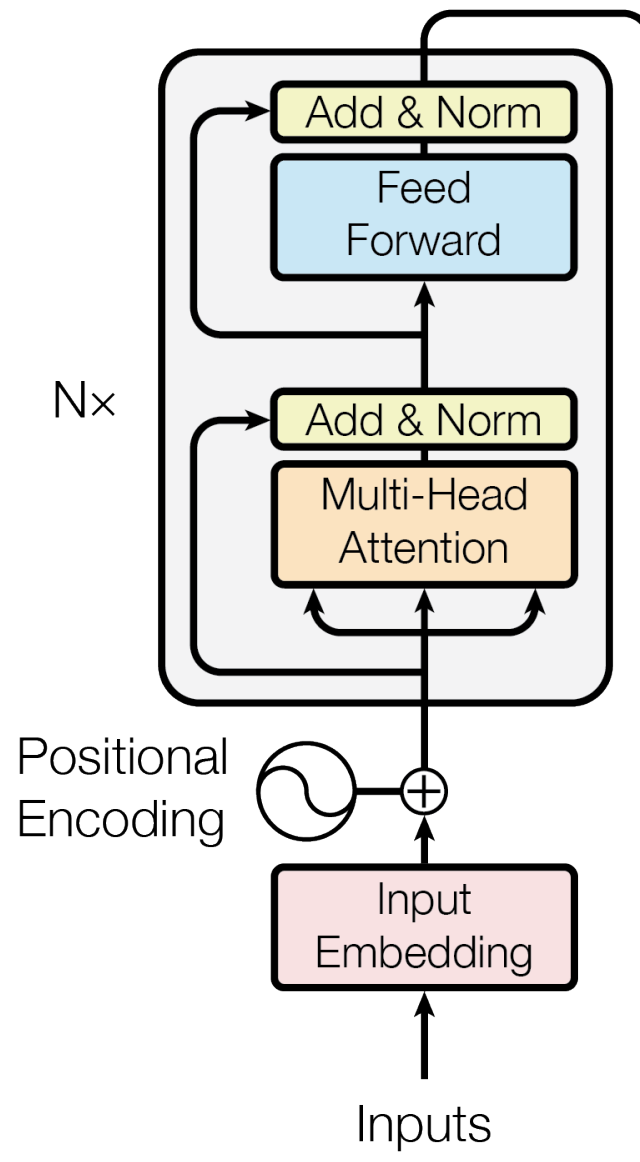

In [7]:
class Encoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_pos_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding and positional encoding for the encoder
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_pos_encoding, d_model)
        
        self.dropout = Dropout(dropout_rate)
        
        # Stack of Encoder Transformer Blocks
        self.encoding_layers = [EncoderTransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.encoding_layers[i](x, training=training, mask=mask)

        return x

## Decoder Stacks

[<img src="./images/transformer/decoder_stacks.png" style="max-width:20%"/>](attachment:aff826a9-bef1-4ab6-b645-80e10a156c6d.png)
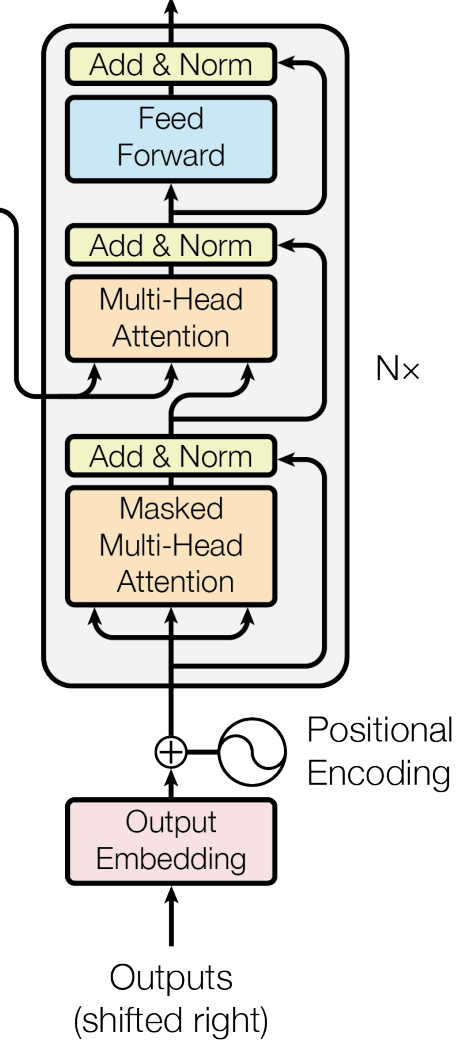

In [8]:
class Decoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_pos_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        
        # Embedding and positional encoding for the decoder
        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_pos_encoding, d_model)
        
        self.dropout = Dropout(dropout_rate)
        
        # Stack of Decoder Transformer Blocks
        self.decoding_layers = [DecoderTransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.decoding_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        return x

## Transformer

In [9]:
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, dropout_rate=0.1)

        self.final_layer = Dense(target_vocab_size)

    def call(self, inputs, targets, training, look_ahead_mask, padding_mask):
        enc_output = self.encoder(inputs, training=training, mask=padding_mask)
        dec_output = self.decoder(targets, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
        
        final_output = self.final_layer(dec_output)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del final_output._keras_mask
        except AttributeError:
          pass

        
        return final_output

In [10]:
# Parameters
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 8500
target_vocab_size = 8000
pe_input = 1000
pe_target = 1000
dropout_rate = 0.1

# Create the Transformer model
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate)

# Example Input
inputs = tf.random.uniform((64, 50), dtype=tf.int64, minval=0, maxval=input_vocab_size)
targets = tf.random.uniform((64, 50), dtype=tf.int64, minval=0, maxval=target_vocab_size)
look_ahead_mask = None
padding_mask = None

# Forward Pass
output = transformer(inputs, targets, training=True, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
print(output.shape)  # (64, 50, target_vocab_size)

(64, 50, 8000)
